# Adding Summarization of the retrieved answers from llms using another llm

## Installing dependencies

In [1]:
with open("requirements.txt", "w") as f:
    f.write("""chromadb
                sentence-transformers
                tree-sitter-languages
                tree-sitter
                tree-sitter-python
                tree-sitter-javascript
                langgraph
            """)

In [2]:
!pip install -r /kaggle/working/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 91.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 95.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.6/575.6 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2

## Importing Codebase from Drive

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
!git clone https://github.com/Healthlane-Technologies/Zango.git


Cloning into 'Zango'...
remote: Enumerating objects: 22087, done.
remote: Counting objects: 100% (2700/2700), done.
remote: Compressing objects: 100% (886/886), done.
remote: Total 22087 (delta 2148), reused 1928 (delta 1773), pack-reused 19387 (from 2)
Receiving objects: 100% (22087/22087), 159.90 MiB | 39.20 MiB/s, done.
Resolving deltas: 100% (11320/11320), done.


## Imports

In [4]:
import os
import json
import re
import time
import ast
import uuid
import numpy as np
from pathlib import Path
import requests
from typing import TypedDict, Optional, List, Annotated, Dict, Any
from chromadb import PersistentClient
from chromadb.config import Settings
from chromadb.utils.batch_utils import create_batches
import tree_sitter_python
import tree_sitter_javascript
from tree_sitter import Language, Parser
import subprocess
from sentence_transformers import SentenceTransformer, CrossEncoder
from transformers import T5ForConditionalGeneration, AutoTokenizer
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from kaggle_secrets import UserSecretsClient
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

2025-05-19 11:01:57.044124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747652517.479993      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747652517.600555      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Defining Variables

In [5]:
user_secrets = UserSecretsClient()
memory = MemorySaver()

BASE_CODE_PATH = "/kaggle/working/Zango"
CHUNK_SIZE = 300
EMBEDDING_MODEL = "all-MiniLM-L6-v2"
SUMMARIZATION_MODEL = "all-MiniLM-L6-v2"
MAX_RECENT_MESSAGES = 5
GROQ_MODEL = "llama3-70b-8192"
GROQ_API_KEY = user_secrets.get_secret('GROQ_API')

## Define Chunker

In [6]:
class CodeChunker:
    def __init__(self):
        self.lang_map = {
            '.py': 'python',
            '.js': 'javascript',
            '.jsx': 'javascript',
            '.ts': 'typescript',
            '.tsx': 'typescript',
        }
        self.parsers = self._initialize_parsers()

    def _initialize_parsers(self):
        """Initialize parsers with proper error handling"""
        parsers = {}
        supported_languages = {'python', 'javascript', 'typescript'}
        
        # Import the tree-sitter module only if it's being used
        try:
            from tree_sitter import Parser
            
            # Attempt to load language libraries
            for lang in supported_languages:
                try:
                    # This assumes you have the language libraries installed
                    from tree_sitter import Language
                    # Get the path to the language library
                    # This is a common pattern, but you might need to adjust paths
                    LANGUAGE_PATH = f"./tree-sitter-{lang}.so"
                    if os.path.exists(LANGUAGE_PATH):
                        language = Language(LANGUAGE_PATH, lang)
                        parser = Parser()
                        parser.set_language(language)
                        parsers[lang] = parser
                    else:
                        print(f"Language library not found for {lang} at {LANGUAGE_PATH}")
                except Exception as e:
                    print(f"Error setting up parser for {lang}: {e}")
        except ImportError:
            print("tree-sitter module not found. Falling back to regex-based chunking.")
        
        return parsers

    def _ast_chunk_python(self, code):
        """AST-based chunking for Python using built-in ast module"""
        try:
            tree = ast.parse(code)
            chunks = []
            
            # Extract imports for context
            imports = []
            for node in ast.walk(tree):
                if isinstance(node, (ast.Import, ast.ImportFrom)):
                    import_lineno = node.lineno
                    import_end_lineno = getattr(node, 'end_lineno', import_lineno)
                    lines = code.split('\n')
                    import_text = '\n'.join(lines[import_lineno-1:import_end_lineno])
                    imports.append(import_text)
            
            # Process functions and classes
            for node in tree.body:
                if isinstance(node, (ast.FunctionDef, ast.ClassDef, ast.AsyncFunctionDef)):
                    # Get the source lines for this node
                    start_line = node.lineno
                    end_line = node.end_lineno if hasattr(node, 'end_lineno') else start_line
                    
                    # Extract the chunk text
                    lines = code.split('\n')
                    chunk_text = '\n'.join(lines[start_line-1:end_line])
                    
                    # Create chunk with metadata
                    node_type = 'class' if isinstance(node, ast.ClassDef) else 'function'
                    if isinstance(node, ast.AsyncFunctionDef):
                        node_type = 'async_function'
                        
                    chunks.append({
                        'code': chunk_text,
                        'type': node_type,
                        'name': node.name,
                        'start_line': start_line,
                        'end_line': end_line
                    })
                    
                    # Process nested functions and classes within classes
                    if isinstance(node, ast.ClassDef):
                        for child_node in node.body:
                            if isinstance(child_node, (ast.FunctionDef, ast.AsyncFunctionDef)):
                                child_start_line = child_node.lineno
                                child_end_line = child_node.end_lineno if hasattr(child_node, 'end_lineno') else child_start_line
                                
                                child_text = '\n'.join(lines[child_start_line-1:child_end_line])
                                
                                child_type = 'method'
                                if isinstance(child_node, ast.AsyncFunctionDef):
                                    child_type = 'async_method'
                                
                                chunks.append({
                                    'code': child_text,
                                    'type': child_type,
                                    'name': child_node.name,
                                    'parent': node.name,
                                    'start_line': child_start_line,
                                    'end_line': child_end_line
                                })
            
            # Add context to chunks
            context = {'imports': imports}
            for chunk in chunks:
                chunk['context'] = context
            
            return chunks or [self._create_full_file_chunk(code)]
        except SyntaxError:
            # Fall back to regex if AST parsing fails
            return self._regex_chunk(code, 'python')

    def _regex_chunk_javascript(self, code, lang):
        """Regex-based chunking for JavaScript/TypeScript"""
        patterns = {
            'function': r'(function)\s+(\w+)\s*\([^)]*\)\s*\{(?:[^{}]|(?:\{[^{}]*\}))*\}',
            'arrow_function': r'(const|let|var)\s+(\w+)\s*=\s*(?:\([^)]*\)|[^=]*)\s*=>\s*\{(?:[^{}]|(?:\{[^{}]*\}))*\}',
            'class': r'(class)\s+(\w+)(?:\s+extends\s+\w+)?\s*\{(?:[^{}]|(?:\{[^{}]*\}))*\}',
            'method': r'(\w+)\s*\([^)]*\)\s*\{(?:[^{}]|(?:\{[^{}]*\}))*\}',
            'component': r'(const|function)\s+(\w+)\s*=?\s*(?:\([^)]*\))?\s*=?\s*(?:=>)?\s*\{\s*(?:.*?return\s*\(?\s*<.*?>.*?<\/.*?>\s*\)?)?(?:[^{}]|(?:\{[^{}]*\}))*\}'
        }
        
        if lang in ['typescript', 'tsx']:
            patterns.update({
                'interface': r'(interface)\s+(\w+)(?:\s+extends\s+\w+)?\s*\{(?:[^{}]|(?:\{[^{}]*\}))*\}',
                'type': r'(type)\s+(\w+)\s*=\s*(?:[^;]|(?:\{[^{}]*\}))*;'
            })
        
        chunks = []
        
        # Extract imports for context
        imports = []
        import_pattern = r'import\s+(?:{[^}]+}|[^;]+)\s+from\s+[\'"]([^\'"]+)[\'"];?'
        for match in re.finditer(import_pattern, code, re.MULTILINE):
            import_text = code[match.start():match.end()]
            imports.append(import_text)
        
        # Extract exports for context
        exports = []
        export_pattern = r'export\s+(?:default\s+)?(?:function|class|const|let|var)?\s*(\w+)'
        for match in re.finditer(export_pattern, code, re.MULTILINE):
            export_text = code[match.start():match.end()]
            exports.append(export_text)
        
        # Process each pattern
        for chunk_type, pattern in patterns.items():
            for match in re.finditer(pattern, code, re.DOTALL):
                # Try to extract name from capture group
                name = match.group(2) if len(match.groups()) > 1 else None
                
                # For methods, which don't have a type identifier in the first group
                if chunk_type == 'method' and not name:
                    name = match.group(1)
                
                chunks.append({
                    'code': match.group(0),
                    'type': chunk_type,
                    'name': name,
                    'start_line': code[:match.start()].count('\n') + 1,
                    'end_line': code[:match.end()].count('\n') + 1,
                    'context': {
                        'imports': imports,
                        'exports': exports
                    }
                })
        
        # Sort chunks by start position
        chunks.sort(key=lambda x: x['start_line'])
        
        return chunks or [self._create_full_file_chunk(code)]

    def _regex_chunk(self, code, lang):
        """Regex fallback chunking with language-specific patterns"""
        if lang == 'python':
            patterns = {
                'function': r'(def)\s+(\w+)\s*\([^)]*\)(?:\s*->.*?)?:\s*(?:\r?\n\s+.+)*(?:\r?\n)*',
                'class': r'(class)\s+(\w+).*?(?:\r?\n(?:\s+[^\r\n]*)?)*',
                'import': r'(from|import)\s+.*?(?:\r?\n)?'
            }
        else:  # For non-Python languages, use the JavaScript/TypeScript chunker
            return self._regex_chunk_javascript(code, lang)
        
        chunks = []
        
        for chunk_type, pattern in patterns.items():
            for match in re.finditer(pattern, code, re.DOTALL):
                # Try to extract name from capture group
                name = match.group(2) if len(match.groups()) > 1 else None
                
                chunks.append({
                    'code': match.group(0),
                    'type': chunk_type,
                    'name': name,
                    'start_line': code[:match.start()].count('\n') + 1,
                    'end_line': code[:match.end()].count('\n') + 1
                })
        
        # Sort chunks by start position
        chunks.sort(key=lambda x: x['start_line'])
        
        return chunks or [self._create_full_file_chunk(code)]

    def _create_full_file_chunk(self, code):
        """Create a full-file chunk when no sub-chunks found"""
        return {
            'code': code,
            'type': 'file',
            'name': None,
            'start_line': 1,
            'end_line': code.count('\n') + 1
        }

    def _extract_node_name(self, node, code):
        """Extract the name of a function, class, etc. from its node"""
        # Look for identifier child node
        for child in node.children:
            if child.type == 'identifier':
                return code[child.start_byte:child.end_byte]
            
        # For JSX/TSX components
        if node.type in ['jsx_element', 'tsx_element']:
            for child in node.children:
                if child.type in ['jsx_opening_element', 'tsx_opening_element']:
                    for grandchild in child.children:
                        if grandchild.type in ['identifier', 'nested_identifier']:
                            return code[grandchild.start_byte:grandchild.end_byte]
        
        return None

    def _process_react_component(self, code, lang):
        """Extract React component details"""
        component_info = {
            'props': [],
            'state': [],
            'hooks': [],
            'jsx_elements': []
        }
        
        # Extract props from function parameters or class props
        props_pattern = r'(?:function|const)\s+\w+\s*\(\s*(?:{([^}]+)}|\s*(\w+)[^)]*)\s*\)'
        props_match = re.search(props_pattern, code)
        if props_match:
            props_str = props_match.group(1) or props_match.group(2)
            if props_str:
                component_info['props'] = [p.strip() for p in props_str.split(',')]
        
        # Extract useState hooks
        state_pattern = r'const\s+\[(\w+),\s*set(\w+)\]\s*=\s*useState'
        for match in re.finditer(state_pattern, code, re.IGNORECASE):
            component_info['state'].append(match.group(1))
        
        # Extract other hooks
        hooks_pattern = r'use(\w+)\('
        for match in re.finditer(hooks_pattern, code):
            if match.group(0) not in ['useState(']:
                component_info['hooks'].append(match.group(0))
        
        # Extract JSX elements (simplified)
        jsx_pattern = r'<(\w+)[^>]*>'
        for match in re.finditer(jsx_pattern, code):
            if match.group(1)[0].isupper():  # Component names start with uppercase
                component_info['jsx_elements'].append(match.group(1))
        
        return component_info

    def _process_django_template(self, code):
        """Extract Django template details"""
        template_info = {
            'blocks': [],
            'includes': [],
            'extends': None,
            'tags': []
        }
        
        # Extract template inheritance
        extends_match = re.search(r'{%\s*extends\s+[\'"]([^\'"]+)[\'"]', code)
        if extends_match:
            template_info['extends'] = extends_match.group(1)
        
        # Extract blocks
        block_pattern = r'{%\s*block\s+(\w+)[^%]*%}'
        for match in re.finditer(block_pattern, code):
            template_info['blocks'].append(match.group(1))
        
        # Extract includes
        include_pattern = r'{%\s*include\s+[\'"]([^\'"]+)[\'"]'
        for match in re.finditer(include_pattern, code):
            template_info['includes'].append(match.group(1))
        
        # Extract custom tags
        tag_pattern = r'{%\s*(\w+)\s'
        for match in re.finditer(tag_pattern, code):
            tag = match.group(1)
            if tag not in ['block', 'endblock', 'if', 'endif', 'for', 'endfor', 'include', 'extends']:
                template_info['tags'].append(tag)
        
        return template_info

    def _extract_context(self, code, lang):
        """Extract imports and other context information"""
        context = {
            'imports': [],
            'exports': [],
            'dependencies': []
        }
        
        # Extract imports based on language
        if lang == 'python':
            import_pattern = r'^(?:from\s+(\S+)\s+import\s+(.+)|import\s+(.+))$'
            for match in re.finditer(import_pattern, code, re.MULTILINE):
                if match.group(1):  # from X import Y
                    module = match.group(1)
                    imports = match.group(2)
                    context['imports'].append(f"from {module} import {imports}")
                    context['dependencies'].append(module)
                else:  # import X
                    imports = match.group(3)
                    context['imports'].append(f"import {imports}")
                    context['dependencies'].append(imports.split('.')[0])
        
        elif lang in ['javascript', 'typescript']:
            # ES6 imports
            import_pattern = r'import\s+(?:{([^}]+)}|([^;]+))\s+from\s+[\'"]([^\'"]+)[\'"]'
            for match in re.finditer(import_pattern, code, re.MULTILINE):
                named_imports = match.group(1)
                default_import = match.group(2)
                module = match.group(3)
                
                if named_imports:
                    context['imports'].append(f"import {{ {named_imports} }} from '{module}'")
                else:
                    context['imports'].append(f"import {default_import} from '{module}'")
                    
                context['dependencies'].append(module)
                
            # ES6 exports
            export_pattern = r'export\s+(?:default\s+)?(?:function|class|const|let|var)?\s*(\w+)'
            for match in re.finditer(export_pattern, code, re.MULTILINE):
                context['exports'].append(match.group(1))
        
        return context

    def chunk_code(self, code, lang):
        """Main chunking method with fallback logic and context preservation"""
        # Extract context information first
        context = self._extract_context(code, lang)
        
        # Use AST for Python, regex for JavaScript/TypeScript
        if lang == 'python':
            chunks = self._ast_chunk_python(code)
        else:
            chunks = self._regex_chunk_javascript(code, lang)
        
        # Add context to each chunk if not already present
        for chunk in chunks:
            if 'context' not in chunk:
                chunk['context'] = context
        
        return chunks

    def process_directory(self, base_path):
        """Process directory with enhanced error handling and metadata"""
        chunks = []
        file_count = 0
        processed_count = 0
        
        for root, _, files in os.walk(base_path):
            for file in files:
                path = Path(root) / file
                if path.suffix not in self.lang_map:
                    continue
                    
                file_count += 1
                try:
                    with open(path, 'r', encoding='utf-8') as f:
                        code = f.read()
                except UnicodeDecodeError:
                    print(f"Skipping non-text file: {path}")
                    continue
                except Exception as e:
                    print(f"Error reading {path}: {e}")
                    continue
                    
                processed_count += 1
                lang = self.lang_map[path.suffix]
                
                # Special handling for Django templates
                if path.suffix == '.html' and ('{% ' in code or '{{ ' in code):
                    template_info = self._process_django_template(code)
                else:
                    template_info = None
                    
                for chunk in self.chunk_code(code, lang):
                    relative_path = str(path.relative_to(base_path))
                    chunk_data = {
                        **chunk,
                        'file': relative_path,
                        'language': lang,
                        'file_size': len(code),
                        'path_parts': relative_path.split('/'),
                    }
                    
                    if template_info:
                        chunk_data['template_info'] = template_info
                        
                    chunks.append(chunk_data)
                    
        print(f"Processed {processed_count}/{file_count} files, extracted {len(chunks)} chunks")
        return chunks


## Define Vector storage

In [7]:
chunker = CodeChunker()
chunks = chunker.process_directory(BASE_CODE_PATH)
with open("code_chunks.json", "w") as f:
    json.dump(chunks, f, indent=2)
print(f"Generated {len(chunks)} chunks in code_chunks.json")

Language library not found for javascript at ./tree-sitter-javascript.so
Language library not found for typescript at ./tree-sitter-typescript.so
Language library not found for python at ./tree-sitter-python.so
Processed 548/548 files, extracted 12422 chunks
Generated 12422 chunks in code_chunks.json


In [8]:
client = PersistentClient(path="./chroma_db")
collection = client.get_or_create_collection(
    name="codebase",
    metadata={"hnsw:space": "cosine"}
)
embedder = SentenceTransformer("all-MiniLM-L6-v2")

with open("/kaggle/working/code_chunks.json") as f:
    chunks = json.load(f)

def validate_metadata(chunk):
    return {k: str(v) for k,v in chunk.items() 
            if k != "code" and isinstance(v, (str, int, float, bool))}

# Prepare all data first
ids = [str(hash(chunk["code"])) for chunk in chunks]  # Simple hashing
documents = [chunk["code"] for chunk in chunks]
metadatas = [validate_metadata(chunk) for chunk in chunks]
embeddings = embedder.encode(
    documents,
    batch_size=64,
    normalize_embeddings=True
).astype(np.float32).tolist()

# Create optimized batches
batches = create_batches(
    api=client,
    ids=ids,
    documents=documents,
    embeddings=embeddings,
    metadatas=metadatas
)

# Insert with error handling
for i, batch in enumerate(batches):
    try:
        collection.add(**batch)
        print(f"Inserted batch {i+1}/{len(batches)}")
    except Exception as e:
        print(f"Failed batch {i}: {str(e)}")
        # Implement retry logic here

print(f"Successfully stored {len(chunks)} chunks")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/195 [00:00<?, ?it/s]

Failed batch 0: chromadb.api.models.Collection.Collection.add() argument after ** must be a mapping, not tuple
Failed batch 1: chromadb.api.models.Collection.Collection.add() argument after ** must be a mapping, not tuple
Failed batch 2: chromadb.api.models.Collection.Collection.add() argument after ** must be a mapping, not tuple
Successfully stored 12422 chunks


## LangGraph

### Define Node

In [9]:
class ChatState(TypedDict):
    question: str
    processed_question: str
    context: List[str]
    answers: List[str]
    final_answer: str
    messages: List[str]
    history_summary: str

### Define Workflow

In [10]:
def create_workflow():
    builder = StateGraph(ChatState)

    def preprocess_with_llama(state): 
        messages = [
            {
                "role": "system",
                "content": "You are an expert at improving search queries for a large language model to executie it properly. Your task is to enhance queries by adding synonyms for key terms and rephrasing short queries to add more context. Return ONLY the enhanced query without explanations and make it meaningfull."
            },
            {
                "role": "user",
                "content": f"Enhance this query: {state['question']}"
            }
        ]
        
        # Call the LLaMA model via Groq 'Client' object has no attribute 'chat'
        try:
            response = requests.post(
                "https://api.groq.com/openai/v1/chat/completions",
                headers={"Authorization": f"Bearer {GROQ_API_KEY}"},
                json={
                    "model": GROQ_MODEL,
                    "messages": messages,
                    "temperature": 0.3,
                    "max_tokens": 1000
                }
            )
            response_data = response.json()

            if "choices" in response_data and len(response_data["choices"]) > 0:
                enhanced_query = response_data["choices"][0]['message']["content"].strip()
                state["processed_question"] = enhanced_query
            else:
                print("Unexpected Format:", {response_data})
                state["processed_question"] = state["question"]
            
        except Exception as e:
            # Fallback to original query if there's an error
            print(f"Error in preprocessing: {e}")
            state["processed_question"] = state["question"]
        
        return state
    
    def retrieve(state):
        query = state.get("processed_question", state["question"])
        embedding = SentenceTransformer("all-MiniLM-L6-v2").encode(query)
        results = collection.query(
            query_embeddings=[embedding.tolist()],
            n_results=10,
            include=["documents", "metadatas"]
        )
        return {"context": results["documents"][0]}

    def rank_and_filter_retrievals(state):
        
        retrieved_docs = state["context"]
        query = state.get("processed_question", state["question"])
        
        # Skip if there are no documents or only one document
        if not retrieved_docs or len(retrieved_docs) <= 1:
            return state
        
        # Use a lightweight cross-encoder for efficiency
        cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-2-v2')
        
        # Score documents in batches for efficiency
        batch_size = 16
        all_scores = []
        
        for i in range(0, len(retrieved_docs), batch_size):
            batch_docs = retrieved_docs[i:i+batch_size]
            pairs = [[query, doc] for doc in batch_docs]
            batch_scores = cross_encoder.predict(pairs)
            all_scores.extend(batch_scores)
        
        # Normalize scores
        scores = np.array(all_scores)
        if len(scores) > 0:
            min_score = scores.min()
            max_score = scores.max()
            if max_score > min_score:
                normalized_scores = (scores - min_score) / (max_score - min_score)
            else:
                normalized_scores = np.ones_like(scores) * 0.5
        else:
            normalized_scores = np.array([])
        
        # Create scored documents
        scored_docs = list(zip(normalized_scores, retrieved_docs))
        
        # Sort by score
        scored_docs.sort(reverse=True)
        
        # Apply adaptive thresholding
        if len(scored_docs) > 0:
            max_score = scored_docs[0][0]
            threshold = max(0.3, max_score * 0.7)  # Dynamic threshold based on top score
            filtered_docs = [doc for score, doc in scored_docs if score >= threshold]
            
            # Ensure we have at least some documents
            if not filtered_docs and scored_docs:
                filtered_docs = [scored_docs[0][1]]
        else:
            filtered_docs = []
        
        # Limit to reasonable number of documents
        max_docs = 5
        top_docs = filtered_docs[:max_docs]
        
        state["context"] = top_docs
        return state


    def identify_missing_functions(state):
        """Analyze retrieved code chunks and identify potentially missing functions"""
        
        # Create a prompt that asks the LLM to identify missing functions
        response = requests.post(
            "https://api.groq.com/openai/v1/chat/completions",
            headers={"Authorization": f"Bearer {GROQ_API_KEY}"},
            json={
                "model": GROQ_MODEL,
                "messages": [{
                    "role": "system",
                    "content": (
                        "You are a code analyzer. Your task is to examine code snippets and identify any functions or dependencies "
                        "that are referenced but not defined in the provided code. Focus on identifying what additional code would be "
                        "needed to fully understand and solve the user's problem."
                    )
                },
                {
                    "role": "user",
                    "content": (
                        f"User Question: {state['question']}\n\n"
                        f"Retrieved Code Snippets:\n{state['context']}\n\n"
                        "Please analyze these code snippets and identify any functions, classes, or dependencies that are referenced "
                        "but not defined in the provided code. List the names of these missing components and briefly explain why "
                        "they might be important for understanding the user's question."
                    )
                }]
            }
        ).json()
        
        missing_functions_analysis = response["choices"][0]["message"]["content"]
        
        return {"missing_functions_analysis": missing_functions_analysis}

    def retrieve_missing_functions(state):
        """Retrieve additional code for missing functions identified in the analysis"""
        
        # Skip if no missing functions were identified
        if not state.get("missing_functions_analysis") or "No missing functions" in state["missing_functions_analysis"]:
            return {"additional_context": []}
        
        # Extract function names from the analysis (simplified approach)
        # In a real implementation, you might want to use regex or more sophisticated parsing
        response = requests.post(
            "https://api.groq.com/openai/v1/chat/completions",
            headers={"Authorization": f"Bearer {GROQ_API_KEY}"},
            json={
                "model": GROQ_MODEL,
                "messages": [{
                    "role": "system",
                    "content": "Extract the names of missing functions from the analysis."
                },
                {
                    "role": "user",
                    "content": f"From this analysis:\n{state['missing_functions_analysis']}\n\nExtract just the names of the missing functions or components as a comma-separated list."
                }]
            }
        ).json()
        
        function_names = response["choices"][0]["message"]["content"].split(",")
        function_names = [name.strip() for name in function_names]
        
        # Retrieve additional code for each identified function
        additional_context = []
        for function_name in function_names:
            if function_name:
                # Use embedding search to find the function definition
                # This assumes you have a similar collection setup as in your retrieve function
                embedding = SentenceTransformer("all-MiniLM-L6-v2").encode(function_name)
                results = collection.query(
                    query_embeddings=[embedding.tolist()],
                    n_results=3,
                    include=["documents", "metadatas"]
                )
                
                if results and "documents" in results and results["documents"]:
                    additional_context.extend(results["documents"][0])
        
        return {"additional_context": additional_context}

    
    def manage_conversation_history(state):
        """Manage the conversation history by keeping recent messages and summarizing older ones"""
        # Add current question to the messages
        state["messages"].append({"role": "user", "content": state["question"]})
        
        if len(state["messages"]) > 2 * MAX_RECENT_MESSAGES:
            # Separate older messages to summarize
            messages_to_summarize = state["messages"][:-MAX_RECENT_MESSAGES]
            recent_messages = state["messages"][-MAX_RECENT_MESSAGES:]
            
            # If there's already a summary, include it for context
            summary_prompt = ""
            if state["history_summary"]:
                summary_prompt = f"Previous conversation summary: {state['history_summary']}\n\n"
            
            # Add messages to summarize
            message_text = ""
            for msg in messages_to_summarize:
                prefix = "User: " if msg["role"] == "user" else "Assistant: "
                message_text += f"{prefix}{msg['content']}\n"
            
            # Generate new summary of older conversations
            response = requests.post(
                "https://api.groq.com/openai/v1/chat/completions",
                headers={"Authorization": f"Bearer {GROQ_API_KEY}"},
                json={
                    "model": GROQ_MODEL,
                    "messages": [{
                        "role": "system",
                        "content": (
                            "You are a conversation summarizer. Condense the following conversation into a brief summary "
                            "that captures the key points discussed and questions asked. Focus on the essential information "
                            "that would be needed for context in future conversation."
                        )
                    },
                    {
                        "role": "user",
                        "content": (
                            f"{summary_prompt}Please summarize this conversation fragment:\n\n{message_text}"
                        )
                    }]
                }
            ).json()
            
            # Update the state with the summary and reduced message list
            state["history_summary"] = response["choices"][0]["message"]["content"]
            state["messages"] = recent_messages
        
        return state
    
    def generate_answers(state):
        # First manage conversation history
        state = manage_conversation_history(state)
        
        # Create messages with context including conversation history
        system_content = f"Relevant code: {state['context']}"
        
        # Add conversation history summary if it exists
        if state.get("history_summary"):
            system_content = f"Previous conversation summary: {state['history_summary']}\n\n{system_content}"
        
        # Combine the most recent messages and system content
        messages = [{"role": msg["role"], "content": msg["content"]} for msg in state["messages"]]
        messages.append({"role": "system", "content": system_content})
        
        answers = []
        for code in state["context"]:
            response = requests.post(
                "https://api.groq.com/openai/v1/chat/completions",
                headers={"Authorization": f"Bearer {GROQ_API_KEY}"},
                json={
                    "model": GROQ_MODEL,
                    "messages": [{
                        "role": "system",
                        "content": (
                            "You are a helpful and friendly support assistant for an internal company software. "
                            "You know how the system works, including its features, permissions, and typical issues users may face. "
                            "Your job is to explain possible reasons for the issue and guide the user to a solution in plain, simple language. "
                            "Avoid technical terms, error codes, or developer jargon. Be clear, supportive, and patient.\n\n"
                            "If the issue might be related to permissions, login state, or a missing step, gently suggest those as things to check. "
                            "Only refer to code if it directly explains behavior, and describe it in user-friendly language.\n\n"
                            "Your answers should be formatted clearly with bullet points or steps if needed.\n"
                        )
                    },
                    {
                        "role": "user",
                        "content": (
                            f"A user is facing an issue with the software.\n\n"
                            f"Previous conversation context: {state.get('history_summary', 'No prior context')}\n\n"
                            f"Here is part of the codebase that may relate to the issue:\n{code}\n\n"
                            f"Recent messages: {state['messages'][-MAX_RECENT_MESSAGES:]}\n\n"
                            f"User's Question: {state['question']}\n\n"
                            "Please provide a clear, non-technical explanation and steps they can follow to solve the issue."
                        )
                    }]
                }
            ).json()
            answers.append(response["choices"][0]["message"]["content"])
        
        # Add the assistant's response to the message history
        state["messages"].append({"role": "assistant", "content": answers[0] if answers else "I couldn't find an answer."})
        
        return {"answers": answers, "messages": state["messages"], "history_summary": state.get("history_summary", "")}

    def summarize(state):
        summary = requests.post(
            "https://api.groq.com/openai/v1/chat/completions",
            headers={"Authorization": f"Bearer {GROQ_API_KEY}"},
            json={
                "model": GROQ_MODEL,
                "messages": [{
                    "role": "system",
                    "content": (
                        "You are a helpful support assistant. Your job is to carefully read multiple assistant answers to a user's question "
                        "and combine them into a single, clear, helpful response. The user is not technical, so avoid using any programming terms or code. "
                        "Explain the issue and the solution in plain, language that's easy to understand."
                    )
                },
                {
                    "role": "user",
                    "content": (
                        f"The user asked the following question:\n{state['question']}\n\n"
                        "Here are several assistant answers that may help explain the problem:\n\n"
                        + "\n".join(state["answers"]) +
                        "\n\nNow, please combine all of this into one simple, clear, and user-friendly explanation of what might be causing the issue and how to fix it."
                    )
                }]
            }
        ).json()
        
        final_answer = summary["choices"][0]["message"]["content"]
        
        # We already added an assistant message in generate_answers, but we can update it with the final answer
        if state["messages"] and state["messages"][-1]["role"] == "assistant":
            state["messages"][-1]["content"] = final_answer
        
        return {
            "final_answer": final_answer, 
            "messages": state["messages"],
            "history_summary": state.get("history_summary", "")
        }

    def generate_answers(state):
        # First manage conversation history
        state = manage_conversation_history(state)
        
        # Combine original context with additional context
        combined_context = state["context"]
        if "additional_context" in state and state["additional_context"]:
            combined_context = combined_context + state["additional_context"]
        
        # Create messages with context including conversation history
        system_content = f"Relevant code: {combined_context}"
        
        # Add conversation history summary if it exists
        if state.get("history_summary"):
            system_content = f"Previous conversation summary: {state['history_summary']}\n\n{system_content}"
        
        # Combine the most recent messages and system content
        messages = [{"role": msg["role"], "content": msg["content"]} for msg in state["messages"]]
        messages.append({"role": "system", "content": system_content})
        
        answers = []
        for code in combined_context:
            response = requests.post(
                "https://api.groq.com/openai/v1/chat/completions",
                headers={"Authorization": f"Bearer {GROQ_API_KEY}"},
                json={
                    "model": GROQ_MODEL,
                    "messages": [{
                        "role": "system",
                        "content": (
                            "You are a helpful and friendly support assistant for an internal company software. "
                            "You know how the system works, including its features, permissions, and typical issues users may face. "
                            "Your job is to explain possible reasons for the issue and guide the user to a solution in plain, language. "
                            "If the issue might be related to permissions, login state, or a missing step, gently suggest those as things to check. "
                            "Only refer to code if it directly explains behavior, and describe it in user-friendly language.\n\n"
                            "Your answers should be formatted clearly with bullet points or steps if needed.\n"
                        )
                    },
                    {
                        "role": "user",
                        "content": (
                            f"A user is facing an issue with the software.\n\n"
                            f"Previous conversation context: {state.get('history_summary', 'No prior context')}\n\n"
                            f"Here is part of the codebase that may relate to the issue:\n{code}\n\n"
                            f"Recent messages: {state['messages'][-MAX_RECENT_MESSAGES:]}\n\n"
                            f"User's Question: {state['question']}\n\n"
                            "Please provide a clear, non-technical explanation and steps they can follow to solve the issue."
                        )
                    }]
                }
            ).json()
            answers.append(response["choices"][0]["message"]["content"])
        
        # Add the assistant's response to the message history
        state["messages"].append({"role": "assistant", "content": answers[0] if answers else "I couldn't find an answer."})
        
        return {"answers": answers, "messages": state["messages"], "history_summary": state.get("history_summary", "")}
    
    builder.add_node("preprocess", preprocess_with_llama)
    builder.add_node("retrieve", retrieve)
    builder.add_node("rank_retrieve", rank_and_filter_retrievals)
    builder.add_node("identify_missing", identify_missing_functions)
    builder.add_node("retrieve_missing", retrieve_missing_functions)
    builder.add_node("generate", generate_answers)
    builder.add_node("summarize", summarize)
    
    builder.set_entry_point("preprocess")
    builder.add_edge("preprocess", "retrieve")
    builder.add_edge("retrieve", "rank_retrieve")
    builder.add_edge("rank_retrieve", "identify_missing")
    builder.add_edge("identify_missing", "retrieve_missing")
    builder.add_edge("retrieve_missing", "generate")
    builder.add_edge("generate", "summarize")
    builder.add_edge("summarize", END)
    
    return builder.compile()

## Generating Response

In [11]:
workflow = create_workflow()
config = {"configurable": {"thread_id": "thread_1"}}
question = input("\nTell me your issue: ")

result = workflow.invoke(
                {"question": question, "messages": []}, 
                 config=config
            )
print("\nFINAL ANSWER:", result["final_answer"])


Tell me your issue:  table meh column add nhi ho raha


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


FINAL ANSWER: I'd be happy to help!

It seems like you're trying to add a new column to a table, but it's not working. Don't worry, we can figure this out!

Here are a few possible reasons why you're facing this issue:

* You might not have the necessary permissions to make changes to the table. 
* The table might be locked or currently in use by someone else or a system process.
* There could be a technical issue on the server-side that's preventing the change from happening.

To resolve this issue, try the following steps:

* Check if you have the required permissions to make changes to the table. If you're not sure, you can contact your system administrator or the person who manages the database.
* Try closing and reopening the database or system to ensure that the table is not locked.
* If the issue persists, reach out to your system administrator or technical support for assistance. They can help identify and resolve any server-side issues.

Remember, if you're still having troub

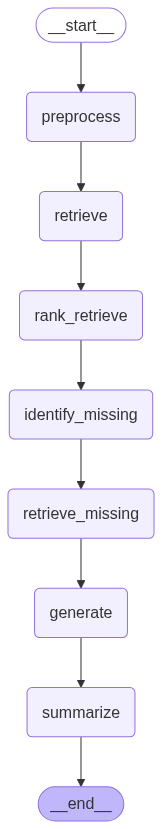

In [14]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_mermaid_png()))
